In [2]:
# Import all necessary libraries 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#import warnings
#warnings.filterwarnings("ignore")

# Data Exploration

In [3]:
# Load data
data = pd.read_csv("./dataset.csv")
data = data.astype(int)
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,2,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


Features and Label

In [4]:
X=data.drop(['Diabetes_012'], axis=1)
y=data['Diabetes_012']
X.shape

(253680, 21)

Let's try backword stepwise elimination (with multinominal logistische regression)

In [23]:
import statsmodels.api as sm

#Add constant for intercept
def multinomial(X): 
    X = sm.add_constant(X)
    cols = list(X.columns)
    pmax = 1

    while len(cols) > 0:
        # Inside your while loop:
        model = sm.MNLogit(y, X[cols]).fit(disp=0)

        # Take max p-value per feature across classes
        p_values = model.pvalues
        p_values_max = p_values.max(axis=1)
        pmax = p_values_max.max()
        feature_with_p_max = p_values_max.idxmax()

        # Backward elimination step
        if pmax > 0.05:
            print(f"Dropping '{feature_with_p_max}' with p = {pmax:.4f}")
            cols.remove(feature_with_p_max)
        else:
            break

    print(f"Selected features: {cols}")
    return cols

X_BSE_list = multinomial(X)
X_BSE_list.remove('const')
X_postBSE = X[X_BSE_list]


Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']


LABEL, CATEGORICAL AND NUMERICAL FEATURES

**Numerical (Interval data** <- has no meaningful zero **) :** 
BMI

**Categorical (Ordinal data) :**
Diabetes_012, Age, GenHlth, MentHlth, PhyaHlth, Education, Income) 

**Categorical (Nominal data) :** Rest 
-> (HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex) 

In [14]:
label = ['Diabetes_012']
num_cols = ['BMI', 'Age']
cate_cols = data.columns.drop(['BMI', 'Age', 'Diabetes_012'])

## Random Forest

Selected features: Index(['HighBP', 'HighChol', 'BMI', 'Smoker', 'HeartDiseaseorAttack',
       'PhysActivity', 'Fruits', 'GenHlth', 'DiffWalk', 'Age'],
      dtype='object')


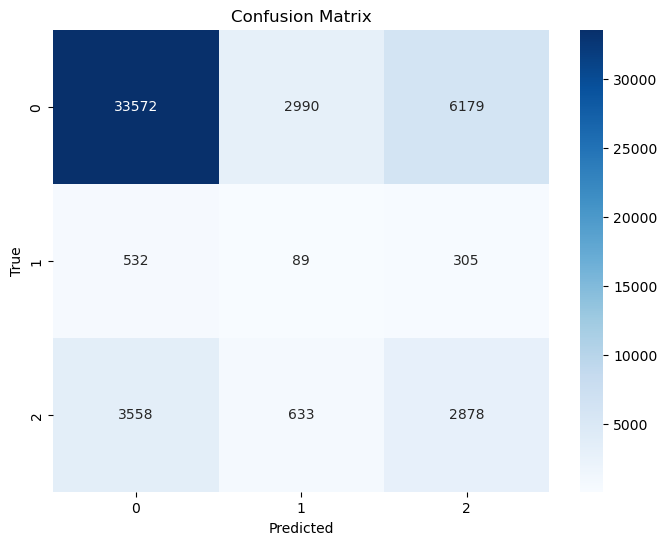

Random Forest Classifier
Accuracy: 0.7201789656259855
Precision: 0.40759723789934804
Recall: 0.4295724456920234
F1 Score: 0.40792842043755667
Log Loss: 1.3613745962207169
Cohen Kappa Score: 0.19502834505517352


In [6]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             log_loss, cohen_kappa_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Select the features
rdf_selector = SelectKBest(score_func=mutual_info_classif, k=10)
rdf_selector.fit(X_scaled, y)
X_rdf= rdf_selector.transform(X_scaled)
selected_features = X.columns[rdf_selector.get_support()]

print("Selected features:", selected_features)

# Create a dataframe with the selected features
X_selected_rdf = pd.DataFrame(X_rdf, columns=selected_features, index=data.index)

# RANDOM FOREST
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X_selected_rdf, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model
rdf.fit(X_train, y_train)

# Prediction
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))



Random forest feature selection

Top Random Forest Features: ['BMI' 'Age' 'Income' 'PhysHlth' 'Education' 'GenHlth']


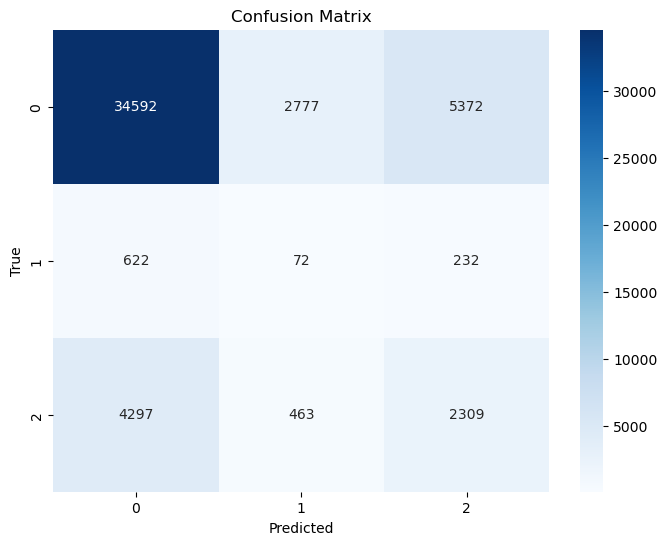

Random Forest Classifier
Accuracy: 0.7287330495111952
Precision: 0.39634682049769393
Recall: 0.4045770629138706
F1 Score: 0.39444574883091293
Log Loss: 1.2424020885623102
Cohen Kappa Score: 0.15503249876643


In [23]:
# Train a Random Forest to get feature importances
temp_rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
temp_rdf.fit(X, y)

# Get feature importances
importances = temp_rdf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top k important features
k=6
top_features = importance_df['Feature'].head(k).values
print("Top Random Forest Features:", top_features)

# Use only the selected features
X_selected_rf = pd.DataFrame(X, columns=X.columns)[top_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected_rf, y, test_size=0.2, random_state=42, stratify=y)

# Train final model
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
rdf.fit(X_train, y_train)

# Predict
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

HPT after FS RF

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, class_weight={0: 1, 1: 15, 2: 10}, max_depth=10, max_features=0.5, m

/Users/miniconda3/envs/jupyter/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, class_weight={0: 1, 1: 15, 2: 10}, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=  11.2s
[CV] END bootstrap=True, class_weight={0: 1, 1: 15, 2: 10}, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=  11.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  17.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  17.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  17.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  17.2s
[CV] END bootstrap=Tru

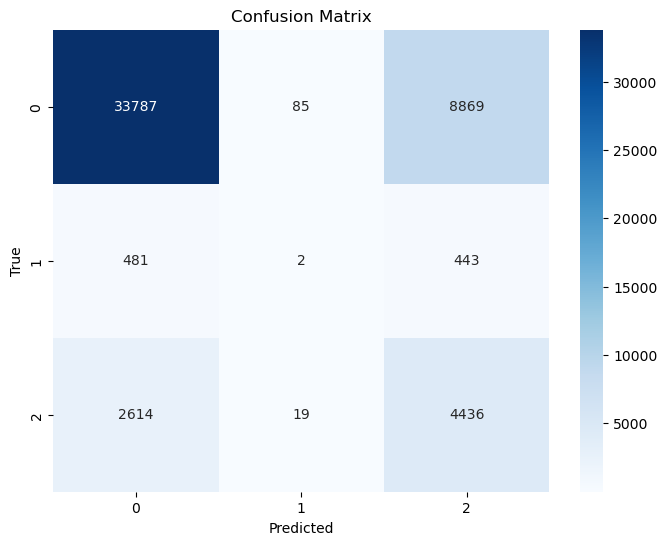

Best parameters from tuning: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': {0: 1, 1: 10, 2: 5}, 'bootstrap': True}
Best CV score: 0.42768659273793574
Accuracy: 0.753409807631662
Precision (macro): 0.4192055886443835
Recall (macro): 0.4733980256448061
F1 Score (macro): 0.4262468266876418

Classification Report:

              precision    recall  f1-score   support

           0     0.9161    0.7905    0.8487     42741
           1     0.0189    0.0022    0.0039       926
           2     0.3227    0.6275    0.4262      7069

    accuracy                         0.7534     50736
   macro avg     0.4192    0.4734    0.4262     50736
weighted avg     0.8170    0.7534    0.7744     50736



In [29]:
from sklearn.model_selection import StratifiedKFold
#==== Train-test split ====
# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X_selected_rf, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)

# ==== Parametri per RandomizedSearch ====
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'class_weight': ['balanced', {0:1, 1:10, 2:5}, {0:1, 1:15, 2:10}]
}

# ==== RandomizedSearch ====
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ==== Fit ====
random_search.fit(X_train, y_train)


# ==== Best Model ====
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==== Metrics ====
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


HPT for random forest I

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif

"""
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_selector = SelectKBest(score_func=f_classif,k=9)
rdf_selector.fit(X_scaled, y)
X_rdf= rdf_selector.transform(X_scaled)
selected_features = X.columns[rdf_selector.get_support()]

print("Selected features:", selected_features)

# Create a dataframe with the selected features
X_selected_rdf = pd.DataFrame(X_rdf, columns=selected_features, index=data.index)
"""

# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)

param_dist = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5, 0.8, None],
    'bootstrap': [True, False]
}

# Random search

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1_macro',  # puoi cambiare qui
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

"""
# Miglior modello
best_rf = random_search.best_estimator_


# Valutazione sul test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)


# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrics
print("Best parameters from tuning:", random_search.best_params_)
print("Accuracy:", best_rf.score(X_test, y_test))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
"""

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.1s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.2s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.3s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.4s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.5s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10; total time=  25.4s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10; total time=  25.6s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10; to

/Users/miniconda3/envs/jupyter/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=  56.9s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=  56.4s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=  55.8s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2; total time=  30.9s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2; total time=  31.3s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2; total time=   6.7s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2; total time=   7.1s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2; total time=  31.4s
[CV] END bootstrap=True, max_depth=5, max_features=

'\n# Miglior modello\nbest_rf = random_search.best_estimator_\n\n\n# Valutazione sul test set\ny_pred = best_rf.predict(X_test)\ny_proba = best_rf.predict_proba(X_test)\n\n\n# Confusion matrix\ncm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])\nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Blues\')\nplt.title(\'Confusion Matrix\')\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'True\')\nplt.show()\n\n# Metrics\nprint("Best parameters from tuning:", random_search.best_params_)\nprint("Accuracy:", best_rf.score(X_test, y_test))\nprint("Precision (macro):", precision_score(y_test, y_pred, average=\'macro\'))\nprint("Recall (macro):", recall_score(y_test, y_pred, average=\'macro\'))\nprint("F1 Score (macro):", f1_score(y_test, y_pred, average=\'macro\'))\nprint("\nClassification Report:\n")\nprint(classification_report(y_test, y_pred, digits=4))\n'

In [17]:
"""
#  ==== Scaling ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==== Feature selection ====
selector = SelectKBest(score_func=f_classif, k=9)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_features, index=data.index)
"""
# ==== Train-test split ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Pipeline ====
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# ==== Parametri per RandomizedSearch ====
param_dist = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True, False],
    'rf__class_weight': ['balanced', {0:1, 1:10, 2:5}, {0:1, 1:15, 2:10}]
}

# ==== RandomizedSearch ====
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ==== Fit ====
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

"""
# ==== Best Model ====
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==== Metrics ====
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
"""

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  54.8s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  56.4s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  56.6s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  48.1s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_spl

/Users/miniconda3/envs/jupyter/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 15, 2: 10}, rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=150; total time= 1.1min
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 15, 2: 10}, rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=150; total time= 1.1min
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time= 1.6min
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 15, 2: 10}, rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=150; total time= 1.1min
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time= 1.6min
[CV] END rf__bootstrap=

KeyboardInterrupt: 

SMOTE + RF. Let's see

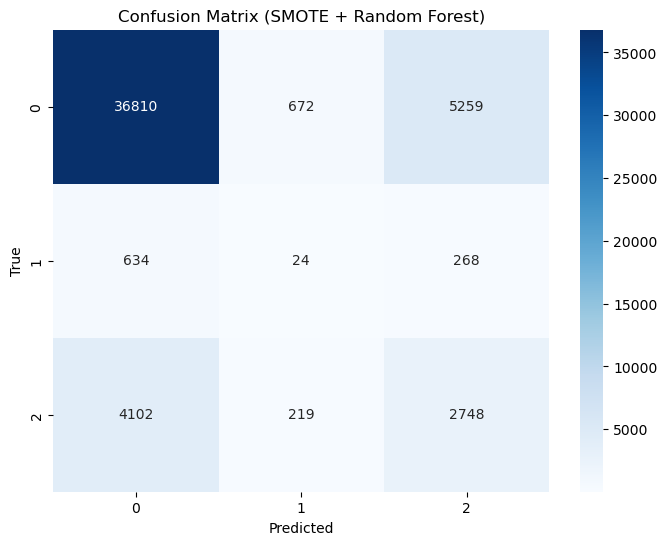

Random Forest Classifier with SMOTE
Accuracy: 0.7801561021759698
Precision (macro): 0.41477332444998943
Recall (macro): 0.4252971458927152
F1 Score (macro): 0.41923423331049
Log Loss: 1.4077177184555372
Cohen Kappa Score: 0.23430657440459035

Classification Report:

              precision    recall  f1-score   support

           0     0.8860    0.8612    0.8734     42741
           1     0.0262    0.0259    0.0261       926
           2     0.3321    0.3887    0.3582      7069

    accuracy                         0.7802     50736
   macro avg     0.4148    0.4253    0.4192     50736
weighted avg     0.7931    0.7802    0.7862     50736



In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Pipeline con SMOTE + Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit della pipeline sul training set
pipeline.fit(X_train, y_train)

# Predizione sul test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SMOTE + Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier with SMOTE")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

# Classification report per classe
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Let's try an undersampling

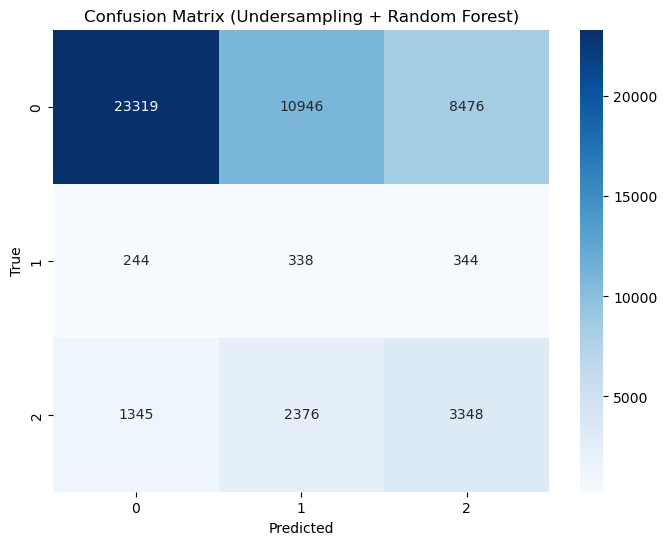

Random Forest Classifier with Random Undersampling
Accuracy: 0.5322650583412173
Precision (macro): 0.41203231390409223
Recall (macro): 0.46140551532007
F1 Score (macro): 0.3612788515394219
Log Loss: 1.5127676052973147
Cohen Kappa Score: 0.14662302711755804

Classification Report:

              precision    recall  f1-score   support

           0     0.9362    0.5456    0.6894     42741
           1     0.0247    0.3650    0.0463       926
           2     0.2751    0.4736    0.3481      7069

    accuracy                         0.5323     50736
   macro avg     0.4120    0.4614    0.3613     50736
weighted avg     0.8275    0.5323    0.6301     50736



In [8]:
from imblearn.under_sampling import RandomUnderSampler


# Pipeline con Undersampling + Random Forest
pipeline = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit della pipeline sul training set
pipeline.fit(X_train, y_train)

# Predizione sul test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Undersampling + Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier with Random Undersampling")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

# Classification report per classe
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))